## Timeseries demo
This notebook illustrates how you can use the time series sevice.



In [1]:
import datetime
import requests
import matplotlib.pyplot as plt
import numpy as np

tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/'

To see which layers are available, we send a request to the service

In [54]:
response = requests.get(tsvBaseURL)
if response.status_code == 200:
    print(response.status_code)
    layerlist = response.json()['layers']
    print(len(layerlist), "layers found")
else:
    raise IOError(response.text)

sorted_layerlist = sorted(layerlist, key= lambda x: x['name'])


200
104


let's investigate the layers that are offered.

In [63]:
count=0

print('Layer name'.ljust(40), 'Ndates'.rjust(6), 'date range'.center(21))
print('---------------------------------------- ------   ------------------------')

for l in sorted_layerlist:
    if len(l['dates'])>0:
        count=count+1
        print(l['name'].ljust(40), '{0:6d}  '.format(len(l['dates'])), min(l['dates'])[:10], 'to', max(l['dates'])[:10])
print()
print(">>>", count, 'layers with data')
print()
print('Layer name'.ljust(40))
print('---------------------------------------- ')
count=0
for l in sorted_layerlist:
    if len(l['dates'])==0:
        count=count+1
        print(l['name'])
print()
print(">>>", count, 'layers without data')


Layer name                               Ndates       date range     
---------------------------------------- ------   ------------------------
BIOPAR_FAPAR300_V1_GLOBAL                   129   2013-10-16 to 2017-05-04
CGLS_LC100_COV_LCCS                        1598   2015-07-04 to 2020-08-08
CHIRPS_RAINFALL                             792   1998-01-11 to 2020-07-21
DCS4COP_CHL_V103                            799   2016-01-02 to 2020-05-30
DCS4COP_CLOUDCOVER_V103                     810   2016-01-02 to 2020-05-30
DCS4COP_FLANDERS_CHL                        454   2017-01-02 to 2018-10-31
DCS4COP_FLANDERS_CHL_V100                   750   2017-01-02 to 2020-02-10
DCS4COP_FLANDERS_CHL_V102                   890   2017-01-02 to 2020-06-02
DCS4COP_FLANDERS_CLOUDCOVER                 454   2017-01-02 to 2018-10-31
DCS4COP_FLANDERS_CLOUDCOVER_L8              159   2017-01-03 to 2018-08-27
DCS4COP_FLANDERS_CLOUDCOVER_L8_V100          38   2019-05-10 to 2019-05-31
DCS4COP_FLANDERS_CLOUDCOVER_V1

Did you see that the COHERENCE layers have a lot more dates? In fact, most dates are in the list more than once.<br>
You can request a time series for a point or for a polygon. Here's two functions that make life easier


In [91]:
def getTimeseriesForPoint(covId,tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                          start=datetime.date(2016,1,1),end=datetime.date(2030,12,31),
                          lat=51.146,lon=3.682,printURL=False):

    tsURL = tsvBaseURL + covId + '/point'
    payload = {
            'lon': str(lon),
            'lat': str(lat),
            'startDate': start.strftime('%Y-%m-%d'),
            'endDate': end.strftime('%Y-%m-%d')
    }
    if printURL:
        print(tsURL,payload)
    response=requests.get(tsURL,params=payload)
    print(response.status_code)
    if response.status_code == 200:
        timeseries = response.json()['results']
        return(timeseries)
    else:

        return([])
    
    

You extract a time series for a point with a <b>get</b> request.<br>
For a time series of a polygon, a <b>post</b> request is needed.

In [89]:
def getTimeseriesForPolygon(covId, polylist,
                            tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                            start=datetime.date(2016,1,1),end=datetime.date(2030,12,31),
                            printURL=False):


    tsURL = tsvBaseURL + covId 
    # print(tsvURL)
    tsURL = tsURL +'/geometry'

    payload = {
            "type": "Feature",
            "geometry": {
            "type": "Polygon",
            "coordinates": [polylist]
            }
        }

    payload['startDate'] = start.strftime('%Y-%m-%d')
    payload['endDate'] = end.strftime('%Y-%m-%d')
    if printURL:
        print(tsURL, payload)
    response=requests.post(url=tsURL,json=payload)
    print(response.status_code)
    if response.status_code==200:
        timeSeries = response.json()['results']   
        return(timeSeries)
    else:
        return([])

In [92]:
for l in sorted_layerlist:
    if 'TERRASCOPE' in l['name']:
        ts = getTimeseriesForPoint(covId=l['name'])
        print(l['name'], len(ts))


500
TERRASCOPE_S1_SLC_COHERENCE_V1_VH 0
500
TERRASCOPE_S1_SLC_COHERENCE_V1_VV 0
TERRASCOPE_S2_FAPAR_V2 813
TERRASCOPE_S2_FCOVER_V2 813
TERRASCOPE_S2_LAI_V2 813
TERRASCOPE_S2_NDVI_V2 813


For some reason, the point timeseries for coherence layers always result in a 500 return message.<br>


In [102]:
ts=getTimeseriesForPoint(covId='TERRASCOPE_S2_NDVI_V2 813',start=datetime.date(2019,1,1),end=datetime.date(2019,12,31),printURL=True)
print(len(ts), 'entries in the time series')
print('these are the valid entries only')
for t in ts:
    if t['result']['validCount']>0:
        print(t['date'], '{0:.3f}'.format(t['result']['average']))

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_NDVI_V2 813/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2019-01-01', 'endDate': '2019-12-31'}
404
0 entries in the time series
these are the valid entries only


2019-01-09 0.592
2019-01-14 0.628
2019-02-03 0.552
2019-02-15 0.584
2019-02-25 0.556
2019-03-22 0.440
2019-03-30 0.512
2019-04-01 0.476
2019-04-04 0.512
2019-04-11 0.476
2019-04-14 0.444
2019-04-19 0.404
2019-04-21 0.316
2019-04-24 0.304
2019-04-26 0.348
2019-04-29 0.388
2019-05-04 0.500
2019-05-11 0.368
2019-05-14 0.388
2019-05-16 0.316
2019-05-24 0.364
2019-05-29 0.468
2019-06-15 0.444
2019-06-18 0.504
2019-06-23 0.672
2019-06-28 0.792
2019-06-30 0.740
2019-07-05 0.876
2019-07-23 0.900
2019-07-25 0.888
2019-07-30 0.888
2019-08-22 0.884
2019-08-24 0.868
2019-08-27 0.832
2019-09-18 0.752
2019-09-21 0.852
2019-10-23 0.336
2019-10-31 0.584
2019-11-05 0.376
2019-11-10 0.556
2019-11-12 0.304
2019-11-17 0.408
2019-11-20 0.384
2019-11-22 0.252
2019-11-30 0.380
2019-12-15 0.356
2019-12-30 0.428


In [42]:
layerpoints=[]
for l in sorted_layerlist:
    if 'COHERENCE' in l['name']:
        print(l['name'])
        dat = l['dates'][0]
        ct = 0
        for d in l['dates']:
            if d == dat:
                ct = ct + 1
            else:
                layerpoints.append([dat, ct])
                dat =d
                ct = 1
print(layerpoints[1:10])    

TERRASCOPE_S1_SLC_COHERENCE_V1_VH
TERRASCOPE_S1_SLC_COHERENCE_V1_VV
[['2016-09-28T00:00:00Z', 5], ['2016-09-29T00:00:00Z', 5], ['2016-10-01T00:00:00Z', 2], ['2016-10-02T00:00:00Z', 3], ['2016-10-03T00:00:00Z', 3], ['2016-10-04T00:00:00Z', 8], ['2016-10-05T00:00:00Z', 5], ['2016-10-06T00:00:00Z', 5], ['2016-10-07T00:00:00Z', 2]]


Let's first extract the timeseries of a point, for all layers that have 'TERRASCOPE' in their name

In [43]:
TSlayers = []
for l in sorted_layerlist:
    if 'TERRASCOPE' in l['name']:
        TSlayers.append(l['name'])
print (TSlayers)

['TERRASCOPE_S1_SLC_COHERENCE_V1_VH', 'TERRASCOPE_S1_SLC_COHERENCE_V1_VV', 'TERRASCOPE_S2_FAPAR_V2', 'TERRASCOPE_S2_FCOVER_V2', 'TERRASCOPE_S2_LAI_V2', 'TERRASCOPE_S2_NDVI_V2']


the COHERENCE layers return a 500 response:

In [7]:
ts=getTimeseriesForPoint(covId='TERRASCOPE_S1_SLC_COHERENCE_V1_VV',start=datetime.date(2020,1,1), end = datetime.date(2020,7,1), printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S1_SLC_COHERENCE_V1_VV/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
500


In [8]:
ts=getTimeseriesForPoint(covId='TERRASCOPE_S1_SLC_COHERENCE_V1_VH',start=datetime.date(2020,1,1), end = datetime.date(2020,7,1), printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S1_SLC_COHERENCE_V1_VH/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
500


But the other layers do return a time series

In [9]:
TSresults=[]
for l in TSlayers:
    if 'COHERENCE' not in l:
        ts = getTimeseriesForPoint(covId=l,start=datetime.date(2020,1,1), end = datetime.date(2020,7,1), printURL=True)
        result={
            'layer': l,
            'values': ts
        }
        TSresults.append(result)


https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_FAPAR_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_LAI_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_NDVI_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}
https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_FCOVER_V2/point {'lon': '3.682', 'lat': '51.146', 'startDate': '2020-01-01', 'endDate': '2020-07-01'}


In [11]:
tseries=[]
for r in TSresults:
    print (r['layer'], len(r['values']))
    tsres={}
    dates=[]
    val =[]
    for t in r['values']:
        tsres['layer'] = r['layer']

        if t['result']['validCount']==1:
            dates.append(t['date'])
            val.append(t['result']['average'])
        tsres['x']=dates
        tsres['y']=val
    tseries.append(tsres)   
            

TERRASCOPE_S2_FAPAR_V2 97
TERRASCOPE_S2_LAI_V2 97
TERRASCOPE_S2_NDVI_V2 97
TERRASCOPE_S2_FCOVER_V2 97


So, the values are now stored in <b>timeSeries</b>. There are many values without valid data (due to cloud cover, so we'll only list those that have a <b>validCount</b> equal to 1. 

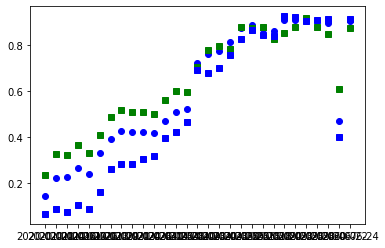

In [12]:
plt.plot(tseries[0]['x'],tseries[0]['y'],'bo',tseries[2]['y'], 'gs', tseries[3]['y'], 'bs')

plt.show()

In [44]:
polygon=[]

point = [3.65, 51.14]
polygon.append(point)
point = [3.66, 51.14]
polygon.append(point)
point = [3.66, 51.15]
polygon.append(point)
point = [3.65, 51.15]
polygon.append(point)
point = [3.65, 51.14]
polygon.append(point)
resultForPoly  = getTimeseriesForPolygon(covId='TERRASCOPE_S1_SLC_COHERENCE_V1_VV',polylist=polygon, start = datetime.date(2020,1,1), end = datetime.date(2020,5,1),printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S1_SLC_COHERENCE_V1_VV/geometry {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[3.65, 51.14], [3.66, 51.14], [3.66, 51.15], [3.65, 51.15], [3.65, 51.14]]]}, 'startDate': '2020-01-01', 'endDate': '2020-05-01'}
200


So, this does return a COHERENCE time series. Good. <br>
The start and end dates are not taken into account, for some reason<br>
Strange things: 
* the totalCount is not always the same 
* sometimes there are invalid data (which is strange, as it cannot be attributed to cloud cover...)


date       valid   total   ratio   avg
---------- ------  ------  ------  -----
2016-09-26  64728   64728  1.0000  0.430
2016-09-29 107880  107880  1.0000  0.324
2016-10-02  64728   64728  1.0000  0.339
2016-10-04 172520  172608  0.9995  0.402
2016-10-05 107880  107880  1.0000  0.390
2016-10-08 107880  107880  1.0000  0.397
2016-10-10  86264   86304  0.9995  0.365
2016-10-11 107880  107880  1.0000  0.465
2016-10-14 107880  107880  1.0000  0.386
2016-10-16  86304   86304  1.0000  0.463
2016-10-17 107880  107880  1.0000  0.391
2016-10-20 107880  107880  1.0000  0.324
2016-10-22  85392   86304  0.9894  0.423
2016-10-23 107880  107880  1.0000  0.400
2016-10-26  86304   86304  1.0000  0.380
2016-10-28  85644   86304  0.9924  0.551
2016-10-29  64728   64728  1.0000  0.550
2016-11-01  86304   86304  1.0000  0.413
2016-11-03  64728   64728  1.0000  0.394
2016-11-04  64728   64728  1.0000  0.470
2016-11-07 107880  107880  1.0000  0.461
2016-11-09  59643   64728  0.9214  0.344
2016-11-10 107880 

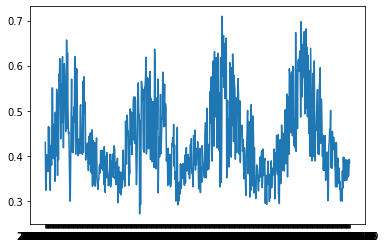

In [15]:
print('date       valid   total   ratio   avg')
print('---------- ------  ------  ------  -----')
x=[]
y=[]
for r in resultForPoly:

    if r['result']['validCount']>0:
        print(r['date'], '{0:6d} '.format(r['result']['validCount']),'{0:6d} '.format(r['result']['totalCount']), '{0:.4f} '.format(r['result']['validCount']/r['result']['totalCount']), '{:.3f}'.format(r['result']['average']))
        x.append(r['date'])
        y.append(r['result']['average'])
        
plt.plot(x, y)

plt.show()

So, let's see if we can extract a time series for FAPAR<br>
Again, the start and end dates are not taken into account <br>
Here, the totalCount is constant. Notice it it just 21576 pixels to a lot more for coherence. How come?

In [20]:
resultForPoly2  = getTimeseriesForPolygon(covId='TERRASCOPE_S2_FAPAR_V2',polylist=polygon, start = datetime.date(2020,1,1), end = datetime.date(2020,5,1),printURL=True)

https://services.terrascope.be/timeseries/v1.0/ts/TERRASCOPE_S2_FAPAR_V2/geometry {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[3.65, 51.14], [3.66, 51.14], [3.66, 51.15], [3.65, 51.15], [3.65, 51.14]]]}, 'startDate': '2020-01-01', 'endDate': '2020-05-01'}
200


date       valid   total   ratio   avg
---------- ------  ------  ------  -----
2015-07-06  20566   21576  0.9532  0.570
2015-07-16  21576   21576  1.0000  0.586
2015-07-29  10927   21576  0.5064  0.516
2015-08-18     65   21576  0.0030  0.304
2015-08-28   9012   21576  0.4177  0.405
2015-11-13   1643   21576  0.0761  0.327
2015-11-26   5922   21576  0.2745  0.628
2015-12-03  21260   21576  0.9854  0.546
2015-12-23  13789   21576  0.6391  0.604
2016-01-02  19124   21576  0.8864  0.535
2016-01-12   8643   21576  0.4006  0.377
2016-01-25  20752   21576  0.9618  0.616
2016-03-12  21576   21576  1.0000  0.535
2016-03-15  21563   21576  0.9994  0.502
2016-03-22   9895   21576  0.4586  0.242
2016-03-25  17634   21576  0.8173  0.455
2016-04-01  21345   21576  0.9893  0.571
2016-04-04  20997   21576  0.9732  0.525
2016-04-14  20997   21576  0.9732  0.462
2016-04-24   2557   21576  0.1185  0.493
2016-05-01  21227   21576  0.9838  0.588
2016-05-04  21250   21576  0.9849  0.590
2016-05-11  20492 

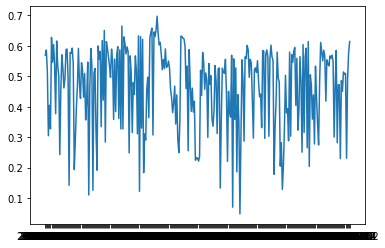

In [21]:
print('date       valid   total   ratio   avg')
print('---------- ------  ------  ------  -----')
x=[]
y=[]
for r in resultForPoly2:

    if r['result']['validCount']>0:
        print(r['date'], '{0:6d} '.format(r['result']['validCount']),'{0:6d} '.format(r['result']['totalCount']), '{:.4f} '.format(r['result']['validCount']/r['result']['totalCount']), '{:.3f}'.format(r['result']['average']))
        x.append(r['date'])
        y.append(r['result']['average'])
        
plt.plot(x, y)

plt.show()

In [45]:
for l in sorted_layerlist:
    if 'GAMMA' in l['name']:
        print(l['name'].ljust(40), '{0:4d}  '.format(len(l['dates'])), min(l['dates'])[:10], 'to', max(l['dates'])[:10])
       

S1_GRD_GAMMA0_ASCENDING_ANGLE             780   2015-01-03 to 2020-06-15
S1_GRD_GAMMA0_ASCENDING_VH                780   2015-01-03 to 2020-06-15
S1_GRD_GAMMA0_ASCENDING_VV                780   2015-01-03 to 2020-06-15
S1_GRD_GAMMA0_DESCENDING_ANGLE           1043   2015-01-07 to 2020-06-15
S1_GRD_GAMMA0_DESCENDING_VH              1043   2015-01-07 to 2020-06-15
S1_GRD_GAMMA0_DESCENDING_VV              1043   2015-01-07 to 2020-06-15
S1_GRD_GAMMA0_VH                         1751   2015-01-03 to 2020-07-23
S1_GRD_GAMMA0_VV                         1751   2015-01-03 to 2020-07-23


In [51]:
for l in sorted_layerlist:
    if 'GAMMA' in l['name']:
        resultForPoly  = getTimeseriesForPolygon(covId=l['name'],polylist=polygon, start = datetime.date(2020,1,1), end = datetime.date(2020,5,1),printURL=False)
        print(l['name'],  resultForPoly[0]['date'] , resultForPoly[-1]['date'])


200
S1_GRD_GAMMA0_ASCENDING_ANGLE 2015-01-13 2020-06-10
200
S1_GRD_GAMMA0_ASCENDING_VH 2015-01-13 2020-06-10
200
S1_GRD_GAMMA0_ASCENDING_VV 2015-01-13 2020-06-10
200
S1_GRD_GAMMA0_DESCENDING_ANGLE 2015-01-29 2020-06-14
200
S1_GRD_GAMMA0_DESCENDING_VH 2015-01-29 2020-06-14
200
S1_GRD_GAMMA0_DESCENDING_VV 2015-01-29 2020-06-14
200
S1_GRD_GAMMA0_VH 2015-01-13 2020-08-03
200
S1_GRD_GAMMA0_VV 2015-01-13 2020-08-03


In [52]:
resultForPoly[-1]

{'result': {'totalCount': 21576,
  'validCount': 21576,
  'average': 0.1412917278200446},
 'date': '2020-08-03'}